# *Advanced SixDman Scenarios*

In [20]:
# Import Dependencies
from pathlib import Path
import numpy as np
import pandas as pd
from sixdman.core.network import Network
from sixdman.core.band import Band, OpticalParameters
from sixdman.core.planning import PlanningTool
from sixdman.core.optical_result_analyzer import analyse_result
import json

# Ignore warnings to have clean cell outputs
import warnings
warnings.filterwarnings("ignore")

### *Create results directory if it doesn't exist*

In [21]:
# Get the current working directory (where the notebook is running)
base_dir = Path.cwd()

# Define the results directory
results_dir = base_dir.parent / "results" / "50G_Complete"

# Create it if it doesn't exist
results_dir.mkdir(exist_ok=True)

print(f"Results will be saved in: {results_dir}")

Results will be saved in: /home/matin/Code Camp/Test_SixDman/results/50G_Complete


### *1. Create Network Instance*

In [22]:
# Initialize network
network = Network(topology_name = 'MAN157')

# Load topology from .mat file
network.load_topology(filepath = '../data/MAN157Nodes.mat', matrixName ='MAN157Nodes')

# Set hierarchical levels
hl_dict = network.define_hierarchy(
    HL1_standalone = [1, 5],
    HL2_standalone = [0, 2, 3, 4],
    HL3_standalone = list(range(6, 39)),
    HL4_standalone = list(range(39, 157))
)

### 2. *Define hierarchy node levels*

In [23]:
HL4_Standalone = hl_dict['HL4']['standalone']
HL4_colocated = hl_dict['HL4']['colocated']

HL3_Standalone = hl_dict['HL3']['standalone']
HL3_colocated = hl_dict['HL3']['colocated']

HL2_Standalone = hl_dict['HL2']['standalone']
HL2_colocated = hl_dict['HL2']['colocated']

HL1_Standalone = hl_dict['HL1']['standalone']

HL123_Standalone = HL1_Standalone + HL2_Standalone + HL3_Standalone
HL12_Standalone = HL1_Standalone + HL2_Standalone


### *3. Define Transmission Bands*

In [24]:
# Define C-band parameters
c_band_params = OpticalParameters()

# Create C-band instance
c_band = Band(
    name='C',
    start_freq = 190.65, # THz
    end_freq = 196.675, # THz
    opt_params = c_band_params,
    network_instance = network,
    channel_spacing = 0.05 # THz
    )

# Define L-band parameters
l_band_params = OpticalParameters()

# Create L-band instance
l_band = Band(
    name='L',
    start_freq = 184.525, # THz
    end_freq = 190.565, # THz
    opt_params = l_band_params,
    network_instance = network,
    channel_spacing = 0.05 # THz
)

In [25]:
# define C-band and L-band frequency slots
spectrum_C = c_band.calc_spectrum()
spectrum_L = l_band.calc_spectrum()

# concatenate C-band and KL-band to a sigle frequency spectrum
spectrum = np.concatenate((spectrum_C, spectrum_L))

# define total number of frequency slots
num_fslots = 240

f_c_axis = spectrum * 1e12  # Convert to Hz
Pch_dBm = np.arange(-6, -0.9, 0.1)  # Channel power in dBm
num_Ch_mat = np.arange(1, len(spectrum) - 1)  # Channel indices

### *4. Create Planning Tool and Optimize Network*

In [26]:
# Initialize planning tool
planner = PlanningTool(
    network_instance = network,
    bands = [c_band, l_band], # simulate network over C and L Band
    period_time = 10) # simulate network for 10 years

#### *4.1 Define number of hierarchical levels*

In [27]:
num_level_process = 4
minimum_hierarchy_level = 4
processing_level_list = [4, 3, 2]
splitter = []

### *5. Simulate network level by level*

In [28]:
# Iterate through each hierarchical levels
for hierarchy_level in processing_level_list:

    print(f"Processing hierarchy level: {hierarchy_level}")

    # Define some variables based on each hierarchical level
    match hierarchy_level:

        case 2:
            HL_Standalone = HL2_Standalone
            HL_colocated = HL2_colocated
            HL_lower_Standalone = HL4_Standalone + HL3_Standalone
            HL_up_Standalone = HL1_Standalone
            HL_all = np.concatenate((HL2_Standalone, HL2_colocated))
            capacity_updt_index = 0
            prev_hierarchy_level = 3
        case 3:
            HL_Standalone = HL3_Standalone
            HL_colocated = HL3_colocated
            HL_lower_Standalone = HL4_Standalone
            HL_up_Standalone = HL12_Standalone
            HL_all = np.concatenate((HL3_Standalone, HL3_colocated))
            capacity_updt_index = 1
            prev_hierarchy_level = 4
        case 4:
            HL_Standalone = HL4_Standalone
            HL_colocated = HL4_colocated
            HL_lower_Standalone = []
            HL_up_Standalone = HL123_Standalone
            HL_all = np.concatenate((HL4_Standalone, HL4_colocated))
            capacity_updt_index = 2
            prev_hierarchy_level = None

    # Calculate subnet matrix of this hierarchical level
    sub_graph_HL, subnetMatrix_HL = network.compute_hierarchy_subgraph(hierarchy_level, minimum_hierarchy_level)

    # Calculate connected nodes to standalone HL (candidate destinations)
    HL_connected_nodes = network.get_neighbor_nodes(HL_Standalone) - set(HL_lower_Standalone)
    splitter.append(len(list(sub_graph_HL.edges())))

    ### Calculate candidate paths for standalone HLs

    # Define CSV file_name for candidate paths for standalone HL nodes
    file_name = results_dir/  f"{network.topology_name}_HL{hierarchy_level}_K_path_attributes.csv"

    # Check if the CSV file exists
    if file_name.exists():

        # If the file exists -> load the CSV file containing candidate paths for standalone HL nodes
        print(f"Loading K-path attributes of HL{hierarchy_level} ...")

        K_path_attributes_df = pd.read_csv(file_name)
        K_path_attributes_df['links'] = K_path_attributes_df['links'].map(json.loads)
        K_path_attributes_df['nodes'] = K_path_attributes_df['nodes'].map(json.loads)

    else:
        # If the file doesn't exist -> calculate candidate paths 

        print(f"Calculating K-path attributes of HL{hierarchy_level} ...")

        # Define number of candidate paths per node
        k_paths = 20

        # Define a variable to store the HL nodes that doesn't have any LAND pair with this k_paths
        source_not_found = HL_Standalone.copy()

        # Continue calculating candiate paths till all the HL nodes have at least one LAND pair
        while len(source_not_found) != 0:

            # define a list to store path attributes for this iteration
            K_path_attributes = []

            # iterate through each "source_not_found" node only
            for src in HL_Standalone:
                for dest in HL_connected_nodes:
                    # Calculate k_paths candidate paths for (src, dest) pair
                    K_path_attributes = network.compute_k_shortest_paths(subnetMatrix_HL, K_path_attributes, source = src, target = dest, k = k_paths)

            # Convert K_path_attributes list to a temporary DataFrame
            K_path_attributes_df = pd.DataFrame(K_path_attributes)

            # Optionally save to CSV (if you want to track progress)
            K_path_attributes_df.to_csv(file_name, index=False)

            # Sort candidate paths dataframe by num_hops and distance
            K_path_attributes_df_sorted = K_path_attributes_df.groupby(['src_node'], group_keys=False).apply(
                lambda x: x.sort_values(['num_hops', 'distance'])
            )

            # find disjoint pairs from the sorted full dataset
            pairs_disjoint = network.land_pair_finder(HL_Standalone, K_path_attributes_df_sorted, num_pairs = 1)

            # Update source_not_found to exclude newly matched source nodes
            source_not_found = np.setdiff1d(HL_Standalone, pairs_disjoint['src_node'].unique())
            
            # Print the Hl nodes that doesn't have LAND pair
            print(f"k_path = {k_paths}, Remaining src nodes: {source_not_found}")

            # Increase the k_paths value by 20 
            k_paths += 20
    
    ### Calculate candidate paths for colocated HLs

    # Define CSV file_name for candidate paths for colocated HL nodes
    file_name = results_dir/ f"{network.topology_name}_HL{hierarchy_level}_K_path_attributes_colocated.csv"

    # Check if the CSV file exists
    if file_name.exists():

        print(f"Loading K-path attributes of HL{hierarchy_level} colocated...")

        # If the file exists -> load the CSV file containing candidate paths for colocated HL nodes
        K_path_attributes_colocated_df = pd.read_csv(file_name)
        K_path_attributes_colocated_df['links'] = K_path_attributes_colocated_df['links'].map(json.loads)
        K_path_attributes_colocated_df['nodes'] = K_path_attributes_colocated_df['nodes'].map(json.loads)

    else:
        # If the file doesn't exist -> calculate candidate paths 

        print(f"Calculating K-path attributes of HL{hierarchy_level} colocated...")
        
        # Define number of candidate paths per node
        k_paths = 20

        # define a list to store path attributes
        K_path_attributes_colocated = []

        # iterate through each colocated HL node
        for src in HL_colocated:
            
            # In the third hierarchical level we can't have standalone HL1 destinations for standalone HL2s 
            if (hierarchy_level == 3) and (src in HL2_Standalone):
                HL_connected_nodes_col = HL_connected_nodes - set(HL1_Standalone)
            else:
                HL_connected_nodes_col = HL_connected_nodes.copy()

            for dest in HL_connected_nodes:
                if src != dest:
                    # Calculate k_paths candidate paths for (src, dest) pair
                    K_path_attributes_colocated = network.compute_k_shortest_paths(subnetMatrix_HL, K_path_attributes_colocated, source = src, target = dest, k = k_paths)

        # Convert K_path_attributes list to dataframe
        K_path_attributes_colocated_df = pd.DataFrame(K_path_attributes_colocated)

        # save dataframe to csv file
        K_path_attributes_colocated_df.to_csv(file_name, index = False)

    
    # sort dataframes based on num_hops and distance (in order)
    K_path_attributes_df_sorted = K_path_attributes_df.groupby(['src_node'], group_keys = False).apply(lambda x: x.sort_values(['num_hops', 'distance']))
    K_path_attributes_colocated_df_sorted = K_path_attributes_colocated_df.groupby(['src_node', 'dest_node'], group_keys = False).apply(lambda x: x.sort_values(['num_hops', 'distance']))

    # find disjoint pairs for HL standalone nodes
    pairs_disjoint = network.land_pair_finder(HL_Standalone, K_path_attributes_df_sorted, num_pairs = 1)

    ### Calculate HL links GSNR
    print(f"process link GSMR of HL{hierarchy_level} ...")

    # Note that if the GSNR values calculated before, the function load the precalculated file
    GSNR_opt_link, _, _, _ = c_band.process_link_gsnr(f_c_axis = f_c_axis, 
                                                  Pch_dBm = Pch_dBm, 
                                                  num_Ch_mat = num_Ch_mat,
                                                  spectrum_C = spectrum_C,
                                                  Nspan_array = np.ones(network.all_links.shape[0], dtype=int),
                                                  hierarchy_level = hierarchy_level, 
                                                  minimum_hierarchy_level = minimum_hierarchy_level, 
                                                  result_directory = results_dir)
    
    ### Initialize planner
    planner.initialize_planner(num_fslots = num_fslots, 
                               hierarchy_level = hierarchy_level,
                               minimum_hierarchy_level = minimum_hierarchy_level)
    
    # Check for being in the minimum hierarchical level
    if hierarchy_level == minimum_hierarchy_level:

        # generate port capacity for minimum HL nodes uisng Monte Carlo simulation
        planner.generate_initial_traffic_profile(num_nodes = len(HL_all),
                                         monteCarlo_steps = 100,
                                         min_rate = 20, # Gbps
                                         max_rate = 200, # Gbps
                                         seed = 50, 
                                         result_directory = results_dir)

        # Traffic growth simulation over 10 years
        planner.simulate_traffic_annual(lowest_hierarchy_dict = hl_dict[f"HL{hierarchy_level}"], 
                                        CAGR = 0.4, 
                                        result_directory = results_dir)
    
    ### Simulate network for this hierarchical level
    print(f"running planner for HL{hierarchy_level} ...")

    # run the planner for the current hierarchy level    
    planner.run_planner(hierarchy_level = hierarchy_level,
                minimum_level = minimum_hierarchy_level,
                pairs_disjoint = pairs_disjoint,
                kpair_standalone = 1,
                kpair_colocated = 1,
                candidate_paths_standalone_df = K_path_attributes_df,
                candidate_paths_colocated_df = K_path_attributes_colocated_df_sorted,
                GSNR_opt_link = GSNR_opt_link,
                prev_hierarchy_level = prev_hierarchy_level,
                node_cap_update_idx = capacity_updt_index, 
                result_directory = results_dir)


Processing hierarchy level: 4
Loading K-path attributes of HL4 ...
Calculating K-path attributes of HL4 colocated...
process link GSMR of HL4 ...
Process Link GSNR: .....
Processing link 0 out of 166
Processing link 1 out of 166
Processing link 2 out of 166
Processing link 3 out of 166
Processing link 4 out of 166
Processing link 5 out of 166
Processing link 6 out of 166
Processing link 7 out of 166
Processing link 8 out of 166
Processing link 9 out of 166
Processing link 10 out of 166
Processing link 11 out of 166
Processing link 12 out of 166
Processing link 13 out of 166
Processing link 14 out of 166
Processing link 15 out of 166
Processing link 16 out of 166
Processing link 17 out of 166
Processing link 18 out of 166
Processing link 19 out of 166
Processing link 20 out of 166
Processing link 21 out of 166
Processing link 22 out of 166
Processing link 23 out of 166
Processing link 24 out of 166
Processing link 25 out of 166
Processing link 26 out of 166
Processing link 27 out of 166

### *6. Plot the results*

#### *6.1 Link state profile*

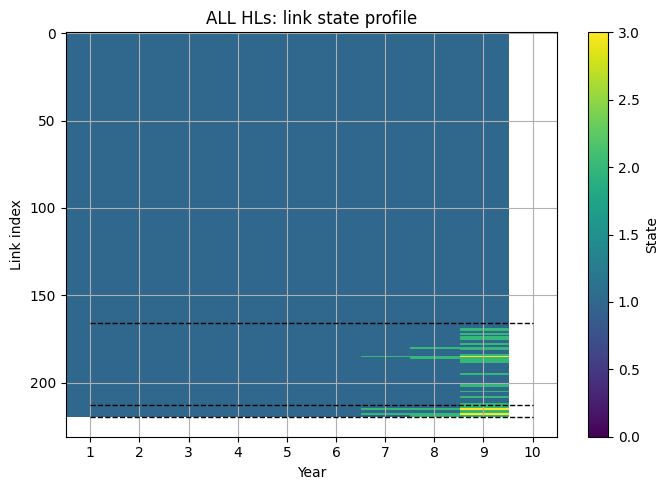

In [39]:
analysing = analyse_result(network, 10, processing_level_list, results_dir)
analysing.plot_link_state(splitter, 
                          save_flag = 0,
                          save_suffix = "_NoBypass")

#### *6.2 Fiber Pair Usage in km and number*

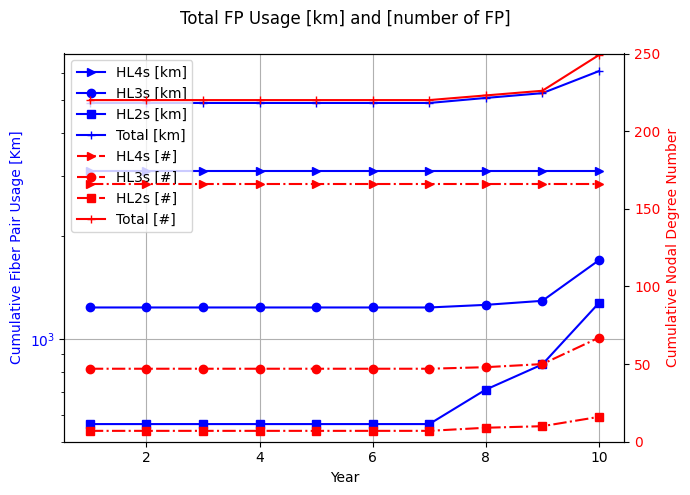

In [40]:
analysing.plot_FP_usage(save_flag = 0, 
                        save_suffix = "_NoBypass")

#### *6.3 Number of BVT and 100G licenses*

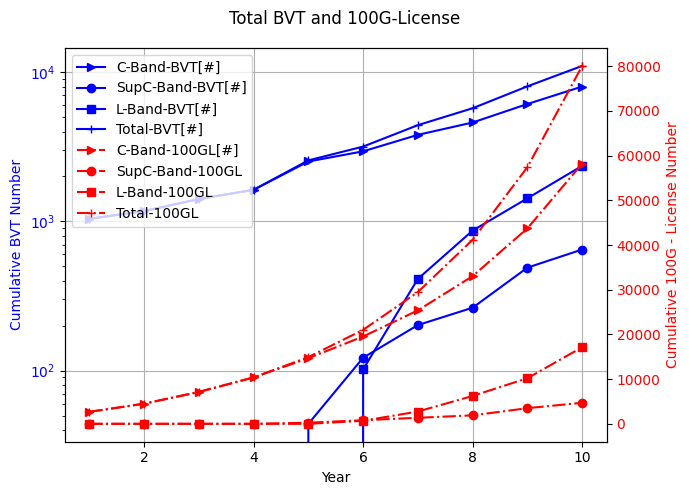

In [31]:
analysing.plot_bvt_license(save_flag = 0, 
                           save_suffix = "_NoBypass")

#### *6.4 Fiber Pair in km and different Band degress*

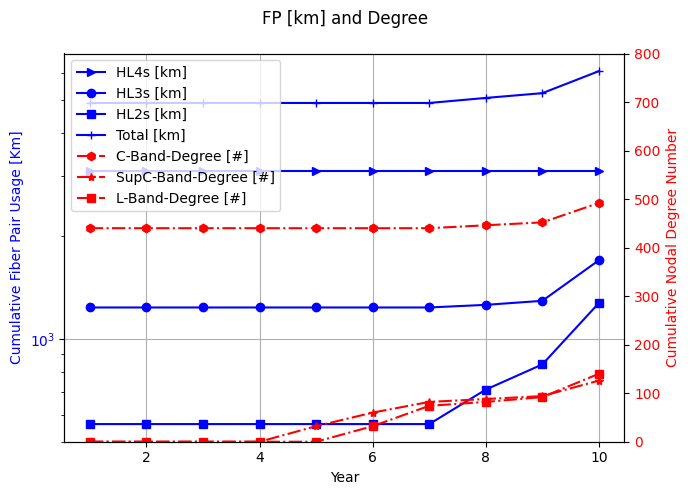

In [32]:
analysing.plot_FP_degree(save_flag = 0, 
                        save_suffix = "_NoBypass")

#### *6.5 Cost analysis*

In [33]:
analysing.calc_cost(save_flag = 0, 
                    save_suffix = "_NoBypass")

,OPEX,Capex_RoB,Capex_MCS,Capex_100GL,CAPEX
0,2450.22,836.000000,45.500000,2680.000000,3561.500000
1,2450.22,0.000000,5.775000,4500.000000,4505.775000
2,2450.22,0.000000,10.500000,7128.000000,7138.500000
3,2450.22,0.000000,9.450000,10384.000000,10393.450000
4,2450.22,3.590179,41.063669,14939.122808,14983.776657
5,2450.22,9.289589,27.255665,21138.829858,21175.375112
6,2450.22,9.632900,55.889784,29811.644034,29877.166718
7,2534.79,13.199353,59.409328,41802.575072,41875.183754
8,2617.77,13.313857,103.081422,58366.580220,58482.975499
9,3036.47,84.479860,133.453395,81443.676819,81661.610073


#### *6.6 Calculate Latency*

In [34]:
analysing.calc_latency(primary_paths = planner.primary_path_storage,
                       processing_level_list = processing_level_list, 
                       save_flag = 0)

array([1011.25,  961.25,  757.5 ,  911.25,  640.  ,  655.  ,  627.5 ,
        622.5 ,  645.  ,  685.  , 1011.25, 1011.25,  681.  ,  678.5 ,
        961.25,  675.  ,  730.  ,  685.  , 1387.95, 1255.45, 1205.45,
       1155.45, 1315.45, 1255.45, 1275.45, 1311.45, 1255.45, 1205.45,
       1252.95, 1308.95, 1360.45, 1315.45, 1305.45, 1270.45, 1257.95,
       1285.45,  707.5 ,  735.  ,  720.  ,  702.5 ,  725.  ,  765.  ,
        755.  ,  765.  ,  810.  ,  761.  ,  880.  ,  830.  ,  758.5 ,
        880.  ,  880.  ,  830.  ,  780.  ,  837.5 ,  945.7 ,  716.55,
       1036.2 ,  691.55,  925.7 ,  905.7 ,  880.7 ,  855.7 ,  900.7 ,
       1111.2 , 1176.2 , 1141.2 ,  996.2 , 1106.2 , 1262.9 , 1036.2 ,
       1117.9 , 1077.9 , 1157.9 , 1137.9 , 1147.9 , 1142.9 , 1260.45,
       1075.45, 1285.45, 1625.45,  961.55, 1600.45, 1280.45, 1305.45,
       1465.45,  926.85,  981.85,  966.85, 1000.45,  650.  ,  695.  ,
        675.  ,  710.  ,  715.  ,  746.55,  706.55,  700.  ,  710.  ,
        680.  ,  655